# Import important libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers, Model
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from itertools import cycle
import math
import pandas as pd

# Get VGG dataset

In [2]:
!ls /kaggle/input/

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


exption-w  vgg2subset


In [3]:
xception_weights = '/kaggle/input/xception-weights/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'
train_dir = '/kaggle/input/vgg2subset/dataset/train'
test_dir = '/kaggle/input/vgg2subset/dataset/test'
val_dir = '/kaggle/input/vgg2subset/dataset/val'

## Ensuring that 'Xception-weights' file exsists

In [4]:
import os

# Example path
image_folder = "/kaggle/input/xception-weights/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Check if the path exists
if os.path.exists(image_folder):
    print(f"The path '{image_folder}' exists.")
else:
    print(f"The path '{image_folder}' does not exist.")

The path '/kaggle/input/xception-weights/xception_weights_tf_dim_ordering_tf_kernels_notop.h5' does not exist.


# Preprocessing functions:

In [5]:
# Set parameters
IMG_HEIGHT = 299
IMG_WIDTH = 299
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE

In [6]:
# Get number of classes
NUM_CLASSES = len(os.listdir(train_dir))
print(f"Number of classes: {NUM_CLASSES}")

# Read and preprocess image
def process_path(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.cast(img, tf.float32)
    img = tf.keras.applications.xception.preprocess_input(img)
    return img, label

# Data augmentation
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    # Random brightness, saturation, and contrast
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_saturation(image, 0.5, 2.0)
    image = tf.image.random_contrast(image, 0.5, 2.0)
    
    # Random crop and resize
    image = tf.image.random_crop(image, [IMG_HEIGHT-30, IMG_WIDTH-30, 3])
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    
    return image, label

# Get class names and create class indices
def create_dataset(directory, is_training=False):
    class_names = sorted(os.listdir(directory))
    class_dict = {name: idx for idx, name in enumerate(class_names)}
    
    # Create lists of paths and labels
    image_paths = []
    labels = []
    
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        for img_name in os.listdir(class_path):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(class_path, img_name)
                image_paths.append(img_path)
                labels.append(class_dict[class_name])
    
    # Create tf.data.Dataset
    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    
    # Shuffle if training
    if is_training:
        ds = ds.shuffle(len(image_paths), reshuffle_each_iteration=True)
    
    # Map preprocessing function
    ds = ds.map(process_path, num_parallel_calls=AUTO)
    
    # Apply augmentation if training
    if is_training:
        ds = ds.map(augment, num_parallel_calls=AUTO)
    
    # Batch and prefetch
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(AUTO)
    
    return ds, len(image_paths)

Number of classes: 80


# Apply preprocessing functions on the dataset

In [7]:
# Create datasets
print("Creating datasets...")
train_ds, train_size = create_dataset(train_dir, is_training=True)
val_ds, val_size = create_dataset(val_dir, is_training=False)
test_ds, test_size = create_dataset(test_dir, is_training=False)

print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Test samples: {test_size}")

Creating datasets...
Training samples: 23223
Validation samples: 2875
Test samples: 2973


# Creating the model

## defining the model function

In [8]:
xception_weights = "/kaggle/input/exption-w/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [9]:
def create_model():
    # Base model
    base_model = Xception(weights=xception_weights, include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    base_model.trainable = False
    
    # Create model
    inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = base_model(inputs, training=False)
    
    # Add custom layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    
    # Dense layers with regularization
    x = layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)
    
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    return Model(inputs, outputs)

## Apply model function

In [10]:
# Create model
model = create_model()

# Compile model
initial_learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy'),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=1e-6)
            ]

## Train the model with 10 epochs

In [11]:
# First training phase
print("Phase 1: Training top layers...")
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)

Phase 1: Training top layers...
Epoch 1/10


I0000 00:00:1734557846.466308      67 service.cc:145] XLA service 0x7b1e6403f9b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734557846.466376      67 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/726 ━━━━━━━━━━━━━━━━━━━━ 3:33:57 18s/step - accuracy: 0.0000e+00 - loss: 5.0666

I0000 00:00:1734557858.929468      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


726/726 ━━━━━━━━━━━━━━━━━━━━ 128s 153ms/step - accuracy: 0.1458 - loss: 3.9579 - val_accuracy: 0.2654 - val_loss: 3.2678 - learning_rate: 0.0010
Epoch 2/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 93s 127ms/step - accuracy: 0.2843 - loss: 3.1174 - val_accuracy: 0.2974 - val_loss: 3.1507 - learning_rate: 0.0010
Epoch 3/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 93s 128ms/step - accuracy: 0.3340 - loss: 2.9411 - val_accuracy: 0.3315 - val_loss: 3.0166 - learning_rate: 0.0010
Epoch 4/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 92s 126ms/step - accuracy: 0.3608 - loss: 2.8798 - val_accuracy: 0.3214 - val_loss: 3.0874 - learning_rate: 0.0010
Epoch 5/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 92s 127ms/step - accuracy: 0.3868 - loss: 2.8360 - val_accuracy: 0.3374 - val_loss: 3.0893 - learning_rate: 0.0010
Epoch 6/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 92s 127ms/step - accuracy: 0.3976 - loss: 2.8131 - val_accuracy: 0.3430 - val_loss: 3.1303 - learning_rate: 0.0010
Epoch 7/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 92s 127ms/step - accuracy: 0.4034 - loss

## Finetune it with 15 epochs

In [12]:
# Fine-tuning phase
print("Phase 2: Fine-tuning Xception layers...")
base_model = model.layers[1]
base_model.trainable = True

# Recompile with lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks
)

Phase 2: Fine-tuning Xception layers...
Epoch 1/15
726/726 ━━━━━━━━━━━━━━━━━━━━ 401s 485ms/step - accuracy: 0.3490 - loss: 3.2322 - val_accuracy: 0.4323 - val_loss: 2.8114 - learning_rate: 1.0000e-05
Epoch 2/15
726/726 ━━━━━━━━━━━━━━━━━━━━ 322s 444ms/step - accuracy: 0.4954 - loss: 2.5537 - val_accuracy: 0.5037 - val_loss: 2.5179 - learning_rate: 1.0000e-05
Epoch 3/15
726/726 ━━━━━━━━━━━━━━━━━━━━ 322s 444ms/step - accuracy: 0.5692 - loss: 2.2805 - val_accuracy: 0.5520 - val_loss: 2.3622 - learning_rate: 1.0000e-05
Epoch 4/15
726/726 ━━━━━━━━━━━━━━━━━━━━ 322s 443ms/step - accuracy: 0.5955 - loss: 2.1539 - val_accuracy: 0.5781 - val_loss: 2.2439 - learning_rate: 1.0000e-05
Epoch 5/15
726/726 ━━━━━━━━━━━━━━━━━━━━ 322s 443ms/step - accuracy: 0.6369 - loss: 2.0034 - val_accuracy: 0.6139 - val_loss: 2.1382 - learning_rate: 1.0000e-05
Epoch 6/15
726/726 ━━━━━━━━━━━━━━━━━━━━ 322s 443ms/step - accuracy: 0.6707 - loss: 1.8844 - val_accuracy: 0.6369 - val_loss: 2.0397 - learning_rate: 1.0000e-05


# Evaluate the model

## Acuuracy of the test dataset (Unseen data)

In [13]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"\nFinal Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")

93/93 ━━━━━━━━━━━━━━━━━━━━ 18s 188ms/step - accuracy: 0.7754 - loss: 1.5069

Final Test Loss: 1.4152
Final Test Accuracy: 0.7948


## Get class names and predictions

In [14]:
# Get class names
class_names = sorted(os.listdir(train_dir))
def get_predictions(model, test_ds):
    y_pred_probs = []
    y_true = []
    
    print("Getting predictions...")
    for images, labels in test_ds:
        pred = model.predict(images, verbose=0)
        y_pred_probs.extend(pred)
        y_true.extend(labels)
    
    return np.array(y_pred_probs), np.array(y_true)

# Get predictions
y_pred_probs, y_true = get_predictions(model, test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

Getting predictions...


## Acuuracy and loss in each epoch

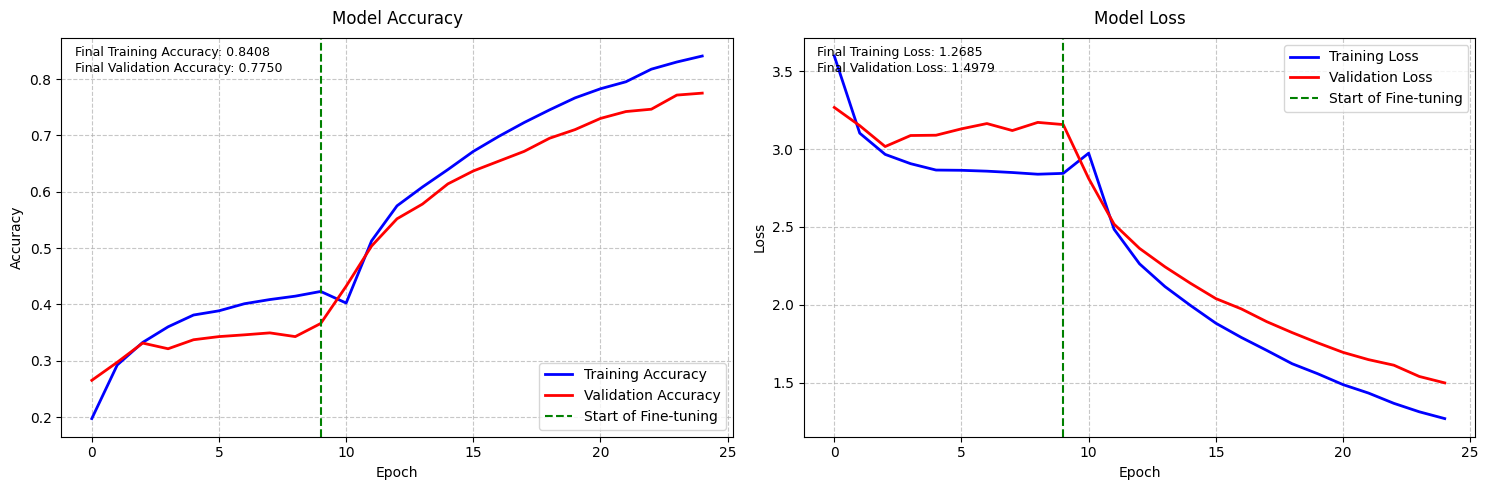


Training Metrics for Each Epoch:

Phase 1 (Initial Training):
----------------------------
Epoch  1/25
Training Accuracy: 0.1975
Validation Accuracy: 0.2654
Training Loss: 3.5982
Validation Loss: 3.2678
----------------------------------------
Epoch  2/25
Training Accuracy: 0.2926
Validation Accuracy: 0.2974
Training Loss: 3.1025
Validation Loss: 3.1507
----------------------------------------
Epoch  3/25
Training Accuracy: 0.3326
Validation Accuracy: 0.3315
Training Loss: 2.9661
Validation Loss: 3.0166
----------------------------------------
Epoch  4/25
Training Accuracy: 0.3603
Validation Accuracy: 0.3214
Training Loss: 2.9065
Validation Loss: 3.0874
----------------------------------------
Epoch  5/25
Training Accuracy: 0.3813
Validation Accuracy: 0.3374
Training Loss: 2.8655
Validation Loss: 3.0893
----------------------------------------
Epoch  6/25
Training Accuracy: 0.3887
Validation Accuracy: 0.3430
Training Loss: 2.8639
Validation Loss: 3.1303
-------------------------------

In [15]:
def plot_training_metrics(history1, history2):
    # Combine histories from both phases
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']
    
    # Create figure with two subplots side by side
    plt.figure(figsize=(15, 5))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(acc, 'b-', label='Training Accuracy', linewidth=2)
    plt.plot(val_acc, 'r-', label='Validation Accuracy', linewidth=2)
    
    # Add vertical line to separate phases
    plt.axvline(x=len(history1.history['accuracy'])-1, color='g', linestyle='--', label='Start of Fine-tuning')
    
    plt.title('Model Accuracy', fontsize=12, pad=10)
    plt.xlabel('Epoch', fontsize=10)
    plt.ylabel('Accuracy', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='lower right', fontsize=10)
    
    # Add text annotations for final values
    plt.text(0.02, 0.98, f'Final Training Accuracy: {acc[-1]:.4f}', 
             transform=plt.gca().transAxes, verticalalignment='top', fontsize=9)
    plt.text(0.02, 0.94, f'Final Validation Accuracy: {val_acc[-1]:.4f}', 
             transform=plt.gca().transAxes, verticalalignment='top', fontsize=9)
    
    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, 'b-', label='Training Loss', linewidth=2)
    plt.plot(val_loss, 'r-', label='Validation Loss', linewidth=2)
    
    # Add vertical line to separate phases
    plt.axvline(x=len(history1.history['loss'])-1, color='g', linestyle='--', label='Start of Fine-tuning')
    
    plt.title('Model Loss', fontsize=12, pad=10)
    plt.xlabel('Epoch', fontsize=10)
    plt.ylabel('Loss', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='upper right', fontsize=10)
    
    # Add text annotations for final values
    plt.text(0.02, 0.98, f'Final Training Loss: {loss[-1]:.4f}', 
             transform=plt.gca().transAxes, verticalalignment='top', fontsize=9)
    plt.text(0.02, 0.94, f'Final Validation Loss: {val_loss[-1]:.4f}', 
             transform=plt.gca().transAxes, verticalalignment='top', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print the values for each epoch
    print("\nTraining Metrics for Each Epoch:")
    print("=================================")
    total_epochs = len(acc)
    
    print("\nPhase 1 (Initial Training):")
    print("----------------------------")
    for epoch in range(len(history1.history['accuracy'])):
        print(f"Epoch {epoch+1:2d}/{total_epochs}")
        print(f"Training Accuracy: {history1.history['accuracy'][epoch]:.4f}")
        print(f"Validation Accuracy: {history1.history['val_accuracy'][epoch]:.4f}")
        print(f"Training Loss: {history1.history['loss'][epoch]:.4f}")
        print(f"Validation Loss: {history1.history['val_loss'][epoch]:.4f}")
        print("-" * 40)
    
    print("\nPhase 2 (Fine-tuning):")
    print("----------------------")
    for epoch in range(len(history2.history['accuracy'])):
        current_epoch = epoch + len(history1.history['accuracy']) + 1
        print(f"Epoch {current_epoch:2d}/{total_epochs}")
        print(f"Training Accuracy: {history2.history['accuracy'][epoch]:.4f}")
        print(f"Validation Accuracy: {history2.history['val_accuracy'][epoch]:.4f}")
        print(f"Training Loss: {history2.history['loss'][epoch]:.4f}")
        print(f"Validation Loss: {history2.history['val_loss'][epoch]:.4f}")
        print("-" * 40)

# After training, call the function:
plot_training_metrics(history1, history2)

## Precision, Recall, and F1-Score matrix

In [16]:
def calculate_average_metrics(y_true, y_pred, class_names):
    # Get classification report as dict
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    
    # Create DataFrame for average metrics
    avg_metrics = pd.DataFrame({
        'Precision': [report['macro avg']['precision']],
        'Recall': [report['macro avg']['recall']],
        'F1-Score': [report['macro avg']['f1-score']]
    }, index=['Macro Average'])
    
    # Add weighted averages
    avg_metrics.loc['Weighted Average'] = [
        report['weighted avg']['precision'],
        report['weighted avg']['recall'],
        report['weighted avg']['f1-score']
    ]
    
    return avg_metrics

# Calculate and display average metrics
avg_metrics = calculate_average_metrics(y_true, y_pred, class_names)
print("Average Metrics:")
print("===============")
print(avg_metrics)

Average Metrics:
                  Precision    Recall  F1-Score
Macro Average      0.794687  0.777405  0.777017
Weighted Average   0.804026  0.794820  0.792012


## ROC Curve


AUC Scores Summary:

Micro-average AUC: 0.9945
Macro-average AUC: 0.9935

Per-Class AUC Scores:
-------------------
n000421: 0.9948
n000422: 0.9818
n000423: 0.9878
n000424: 0.9871
n000425: 0.9968
n000426: 0.9941
n000427: 0.9992
n000428: 0.9980
n000429: 0.9941
n000430: 0.9958
n000431: 0.9950
n000432: 0.9975
n000433: 0.9974
n000434: 0.9986
n000435: 0.9945
n000436: 0.9950
n000437: 0.9821
n000438: 0.9978
n000439: 0.9570
n000440: 0.9819
n000441: 0.9943
n000442: 0.9979
n000443: 0.9952
n000444: 0.9847
n000445: 0.9904
n000446: 0.9945
n000447: 0.9883
n000448: 0.9934
n000449: 0.9997
n000450: 0.9911
n000451: 0.9941
n000453: 0.9934
n000454: 0.9949
n000455: 0.9919
n000456: 0.9901
n000457: 0.9658
n000458: 0.9942
n000459: 0.9997
n000460: 0.9956
n000461: 0.9981
n000462: 0.9964
n000463: 0.9981
n000464: 0.9989
n000465: 0.9966
n000466: 0.9999
n000467: 0.9989
n000468: 0.9979
n000469: 0.9997
n000470: 0.9997
n000471: 0.9993
n000472: 0.9959
n000473: 0.9968
n000474: 0.9983
n000475: 0.9994
n000476: 0.9981
n00

/tmp/ipykernel_23/1083410380.py:63: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


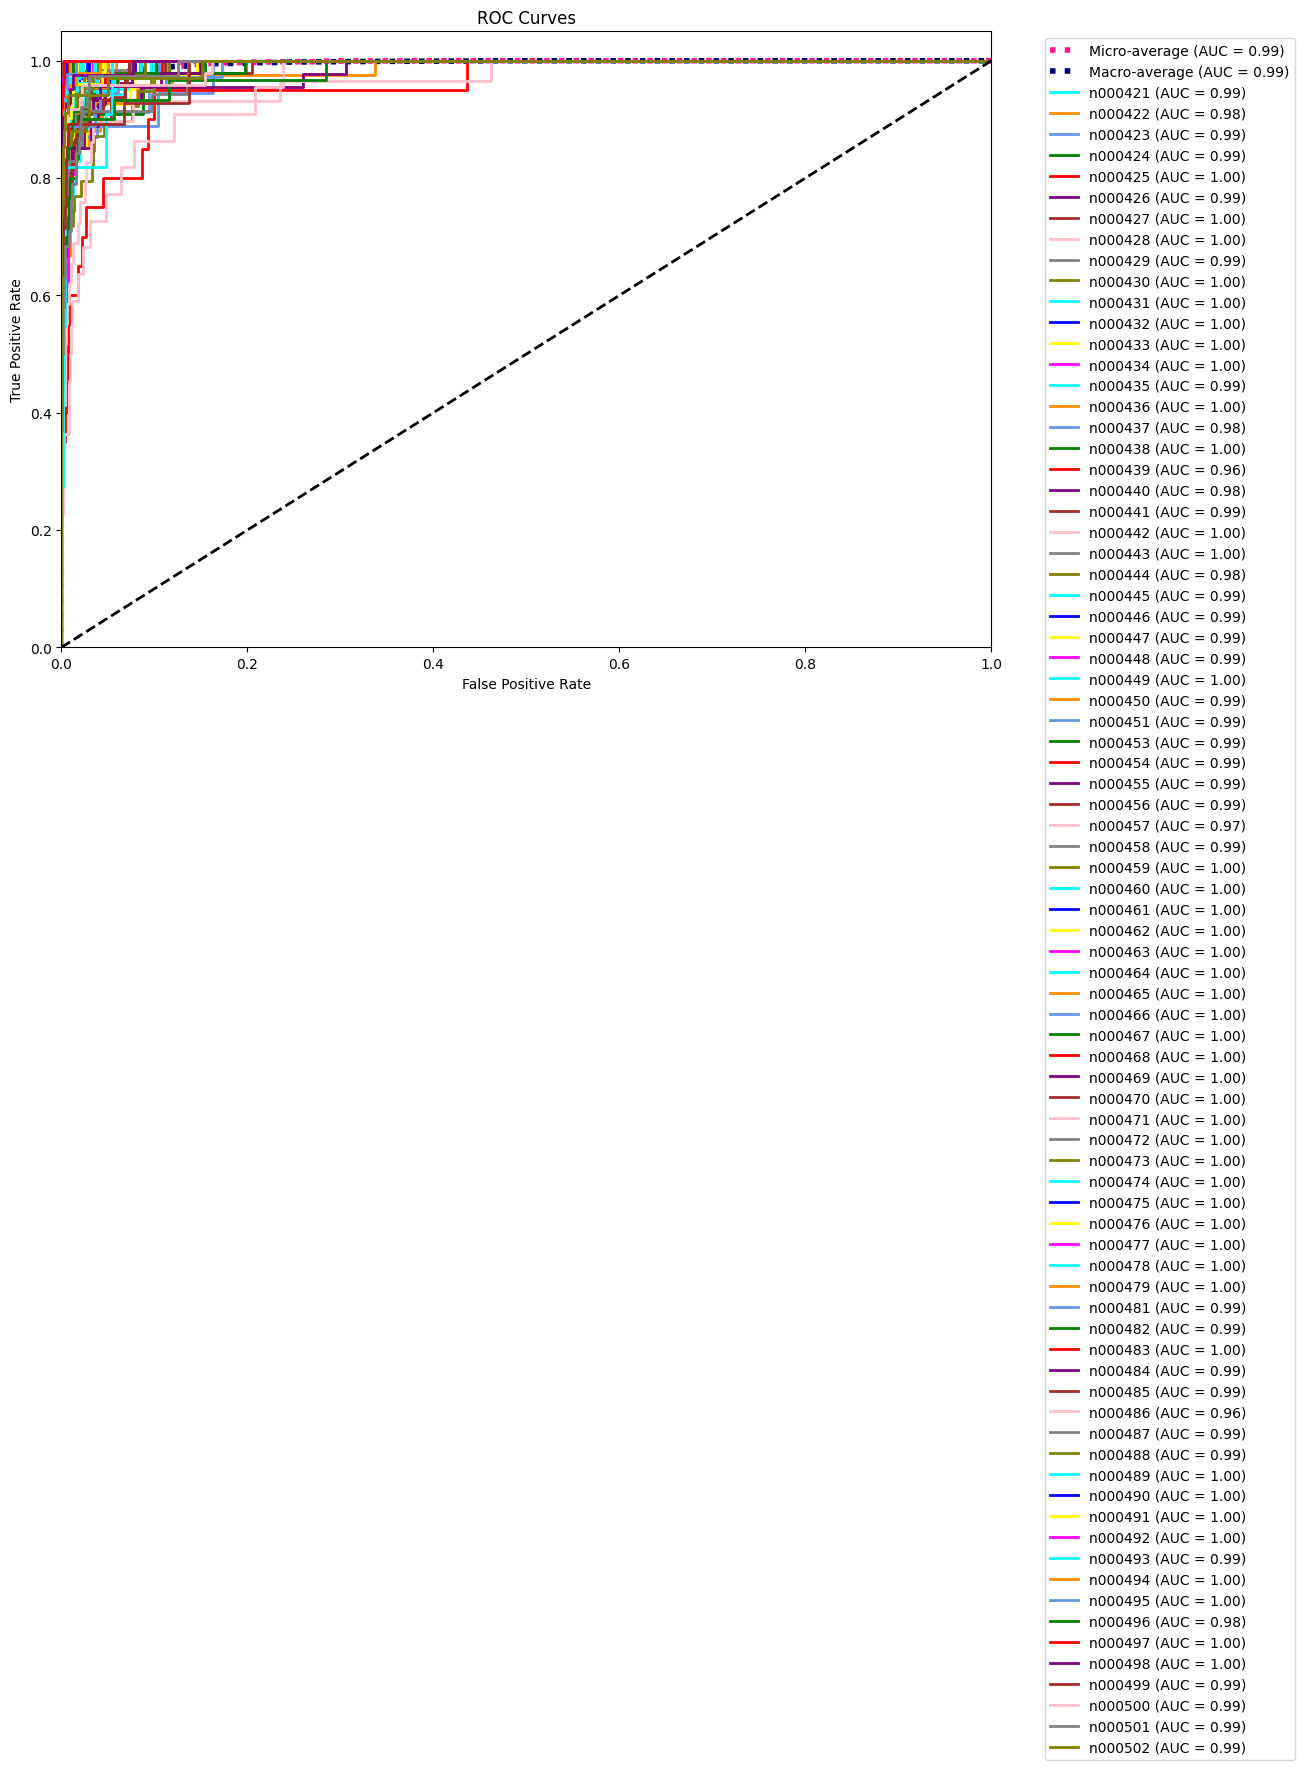

In [17]:
def plot_roc_curves(y_true, y_pred_probs, class_names):
    # Convert to one-hot encoding
    y_true_binary = tf.keras.utils.to_categorical(y_true, num_classes=len(class_names))
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binary.ravel(), y_pred_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Compute macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(class_names)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(class_names)
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Print AUC scores
    print("\nAUC Scores Summary:")
    print("==================")
    print(f"\nMicro-average AUC: {roc_auc['micro']:.4f}")
    print(f"Macro-average AUC: {roc_auc['macro']:.4f}")
    print("\nPer-Class AUC Scores:")
    print("-------------------")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {roc_auc[i]:.4f}")
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    
    # Plot averages
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)
    plt.plot(fpr["macro"], tpr["macro"],
             label=f'Macro-average (AUC = {roc_auc["macro"]:.2f})',
             color='navy', linestyle=':', linewidth=4)
    
    # Plot individual classes
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple',
                   'brown', 'pink', 'gray', 'olive', 'cyan', 'blue', 'yellow', 'magenta'])
    for i, (color, class_name) in enumerate(zip(colors, class_names)):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'{class_name} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # Create and return DataFrame with AUC scores
    auc_scores = {
        'Class': class_names + ['Micro-average', 'Macro-average'],
        'AUC': [roc_auc[i] for i in range(len(class_names))] + [roc_auc['micro'], roc_auc['macro']]
    }
    auc_df = pd.DataFrame(auc_scores)
    
    return auc_df

# Plot ROC curves and get AUC scores
auc_scores = plot_roc_curves(y_true, y_pred_probs, class_names)

# Confusion matrix for each class

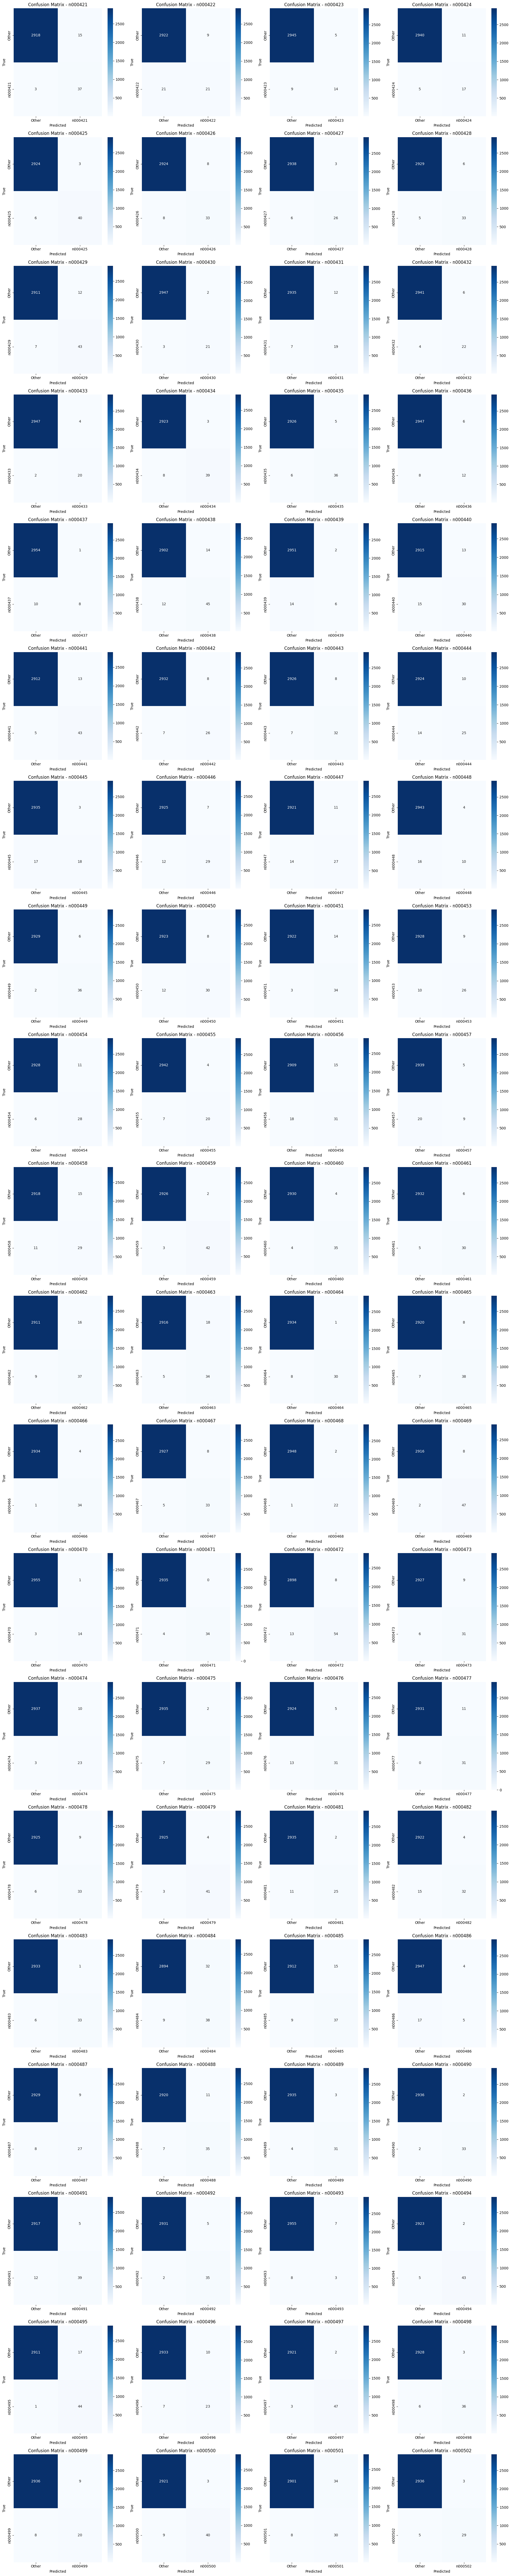

In [18]:
def plot_per_class_confusion_matrices(y_true, y_pred, class_names):
    # Calculate number of rows and columns for subplot grid
    n_classes = len(class_names)
    n_cols = 4  # You can adjust this
    n_rows = math.ceil(n_classes / n_cols)
    
    # Create figure
    plt.figure(figsize=(20, 5 * n_rows))
    
    for idx, class_name in enumerate(class_names):
        # Create binary labels for this class
        y_true_binary = (y_true == idx).astype(int)
        y_pred_binary = (y_pred == idx).astype(int)
        
        # Calculate confusion matrix
        cm = confusion_matrix(y_true_binary, y_pred_binary)
        
        # Create subplot
        plt.subplot(n_rows, n_cols, idx + 1)
        
        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Other', class_name],
                   yticklabels=['Other', class_name])
        
        plt.title(f'Confusion Matrix - {class_name}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
    
    plt.tight_layout()
    plt.show()

plot_per_class_confusion_matrices(y_true, y_pred, class_names)

## Confusion matrix Of all classes 

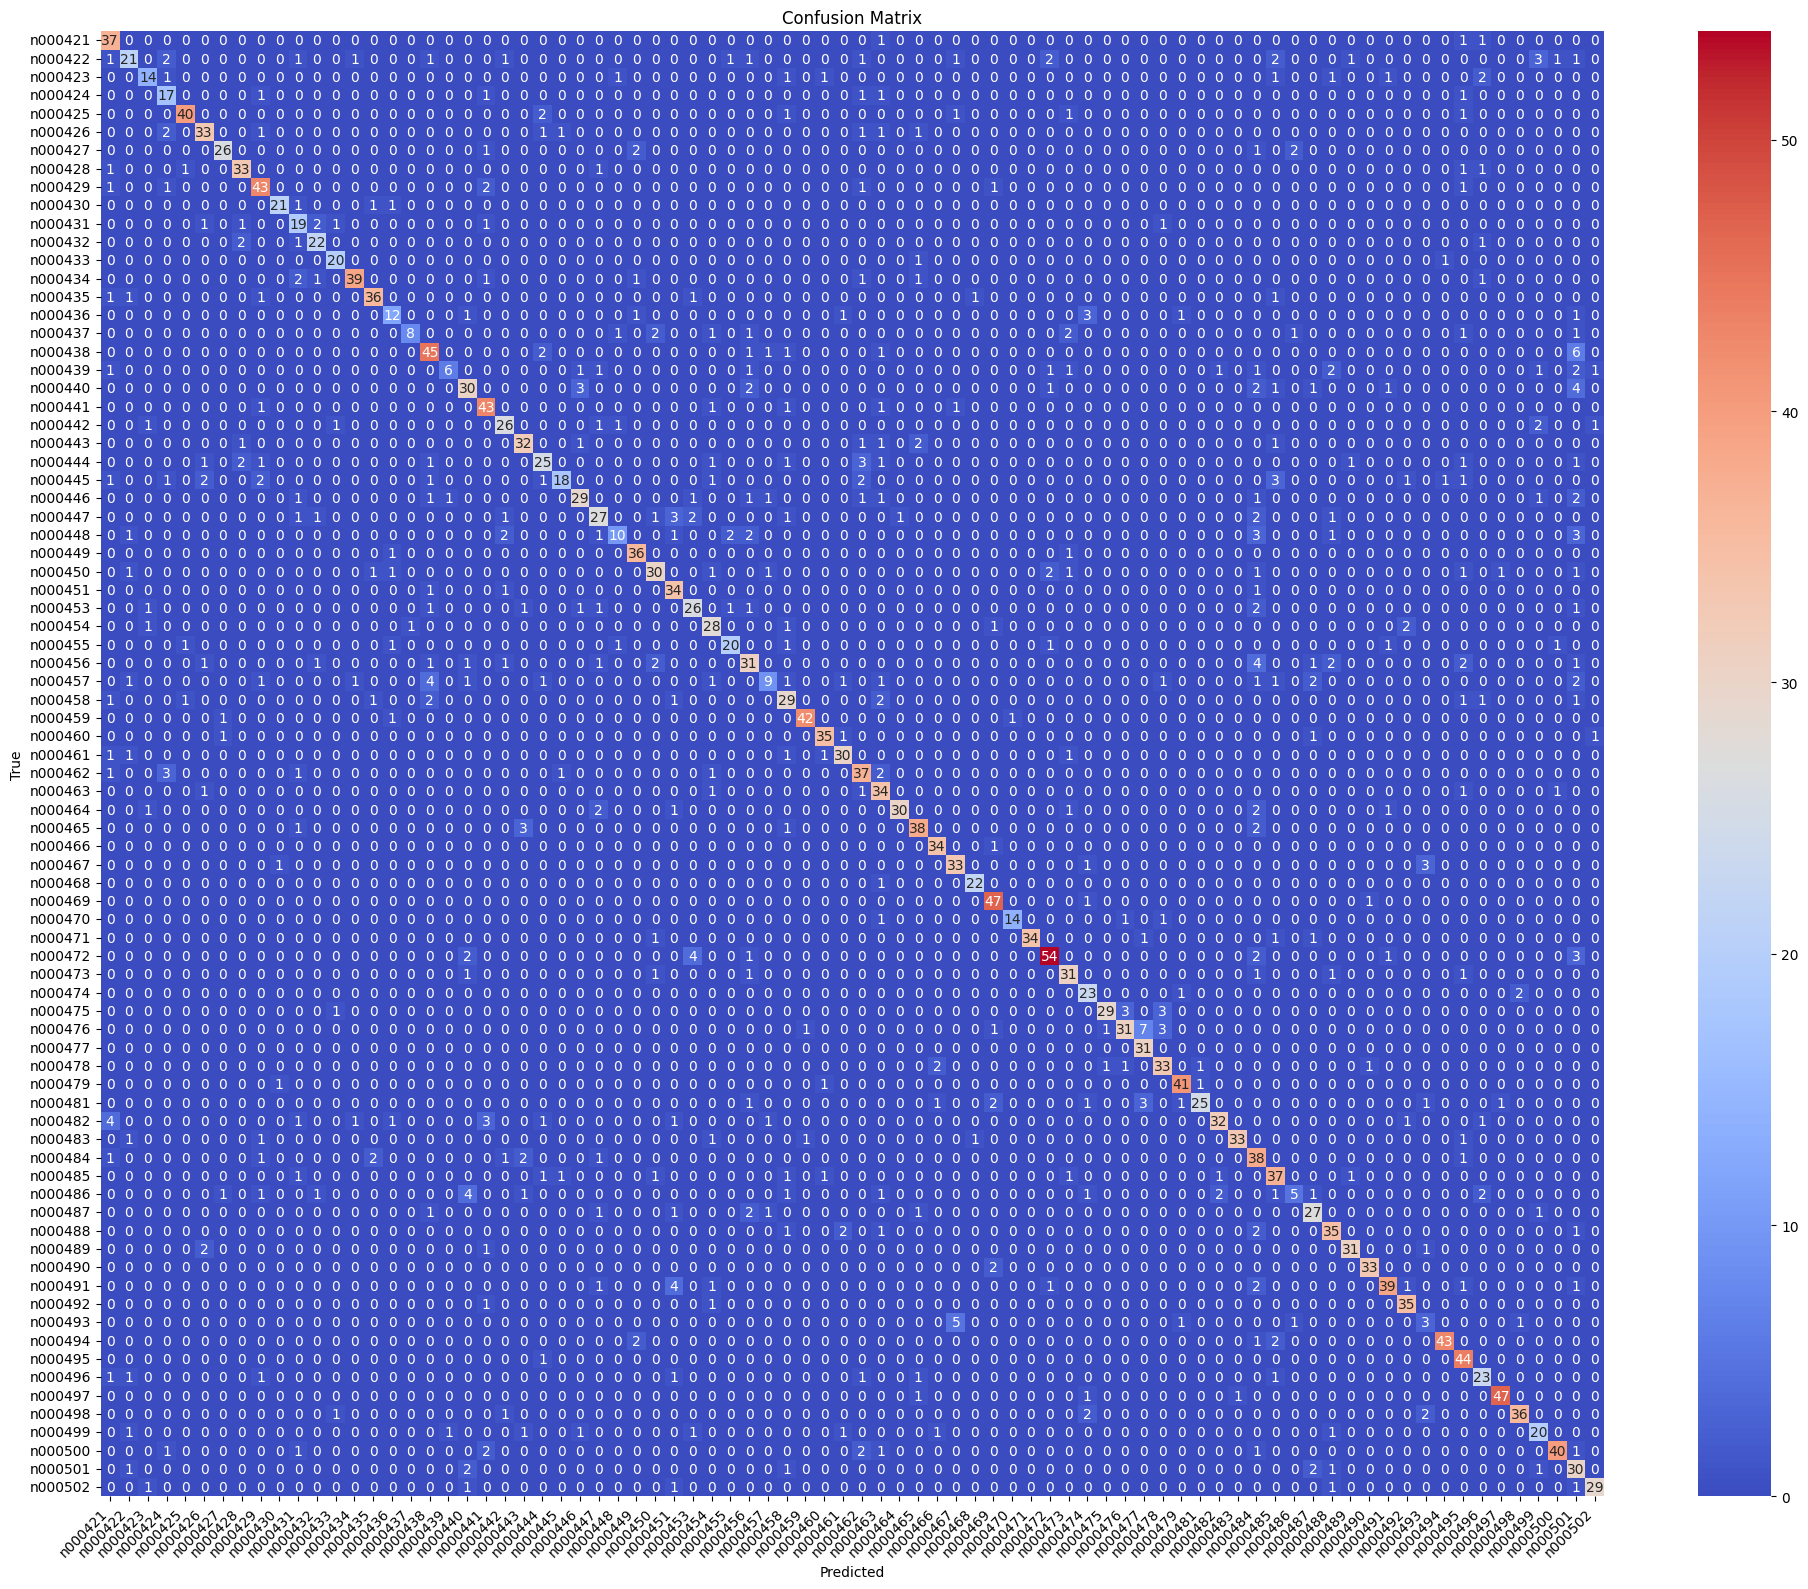

In [19]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(20, 16))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    return cm

# Plot confusion matrix
cm = plot_confusion_matrix(y_true, y_pred, class_names)